# Домашнее задание №7: деревья, случайный лес (14.5 баллов)
<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

$$ H = -\sum(p_i*ln(p_i)) = -(0.8*ln(0.8) + 0.2*ln(0.2)) = 0.5 $$

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

$$ Q = impurity(H) - impurity(Hl) - impurity(Hr) = \sum(p_i*(1-p_i) - \sum(p_l*(1-p_l)) - \sum(p_r*(1-p_r)) = 0.8*0.2 + 0.2*0.8 - 1*0 - 0*1 = 0.32 $$

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

$$ Pred = (\sum(t_i))/n = 40.6 $$

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [65]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [66]:
sorted(X["CRIM"])

[0.00632,
 0.00906,
 0.01096,
 0.01301,
 0.01311,
 0.0136,
 0.01381,
 0.01432,
 0.01439,
 0.01501,
 0.01501,
 0.01538,
 0.01709,
 0.01778,
 0.0187,
 0.01951,
 0.01965,
 0.02009,
 0.02055,
 0.02177,
 0.02187,
 0.02498,
 0.02543,
 0.02729,
 0.02731,
 0.02763,
 0.02875,
 0.02899,
 0.02985,
 0.03041,
 0.03049,
 0.03113,
 0.0315,
 0.03237,
 0.03306,
 0.03359,
 0.03427,
 0.03445,
 0.03466,
 0.03502,
 0.0351,
 0.03537,
 0.03548,
 0.03551,
 0.03578,
 0.03584,
 0.03615,
 0.03659,
 0.03705,
 0.03738,
 0.03768,
 0.03871,
 0.03932,
 0.03961,
 0.04011,
 0.04113,
 0.04203,
 0.04294,
 0.04297,
 0.04301,
 0.04337,
 0.04379,
 0.04417,
 0.04462,
 0.04527,
 0.04544,
 0.0456,
 0.0459,
 0.04666,
 0.04684,
 0.04741,
 0.04819,
 0.04932,
 0.04981,
 0.05023,
 0.05059,
 0.05083,
 0.05188,
 0.05302,
 0.0536,
 0.05372,
 0.05425,
 0.05479,
 0.05497,
 0.05515,
 0.05561,
 0.05602,
 0.05644,
 0.05646,
 0.0566,
 0.05735,
 0.0578,
 0.05789,
 0.06047,
 0.06076,
 0.06127,
 0.06129,
 0.06151,
 0.06162,
 0.06211,
 0.06263,

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

In [67]:

from typing import Iterable, List, Tuple

In [68]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    #для разных типов признаков и типов задач рассчитаем коэффициент Джини (для классификации), или дисперсии (для регрессии)
    if feature_type == 'real':
        feature_un = np.sort(np.unique(feature_vector))
        th0, _ = np.unique(feature_vector, return_counts=True)
        th1 = np.append(0, th0)[:-1]
        thresholds = ((th0+th1)*1./2)[1:]

        if task == 'classification':

            ginis = []
            df = np.c_[feature_vector, target_vector]
            def H(R):
                p1 = (R[:, 1].sum())/len(R)
                p0 = 1 - p1
                return 1-(p1**2)-(p0**2)

            for f in thresholds:
                Rl = df[np.where(feature_vector < f)]
                Rr = df[np.where(feature_vector > f)]
                Gini = len(Rl)/len(feature_vector)*H(Rl)+len(Rr)/len(feature_vector)*H(Rr)
                ginis.append(Gini)

        if task == 'regression':

            ginis = []
            df = np.c_[feature_vector, target_vector]
            def H(R):
                return ((((R[:, 0] - R[:, 0].mean())**2).sum())/len(R))

            for f in thresholds:
                Rl = df[np.where(feature_vector < f)]
                Rr = df[np.where(feature_vector > f)]
                Gini = len(Rl)/len(feature_vector)*H(Rl)+len(Rr)/len(feature_vector)*H(Rr)
                ginis.append(Gini)
                
    if feature_type == 'categorical':
        
        thresholds = np.unique(feature_vector)

        if task == 'classification':

            ginis = []
            df = np.c_[feature_vector, target_vector]
            def H(R):
                p1 = (R[:, 1].sum())/len(R)
                p0 = 1 - p1
                return 1-(p1**2)-(p0**2)

            for f in thresholds:
                Rl = df[np.where(feature_vector == f)]
                Rr = df[np.where(feature_vector != f)]
                Gini = len(Rl)/len(feature_vector)*H(Rl)+len(Rr)/len(feature_vector)*H(Rr)
                ginis.append(Gini)

        if task == 'regression':

            ginis = []
            df = np.c_[feature_vector, target_vector]
            
            def H(R):
                return ((((R[:, 0] - R[:, 0].mean())**2).sum())/len(R))

            for f in thresholds:
                Rl = df[np.where(feature_vector == f)]
                Rr = df[np.where(feature_vector != f)]
                Gini = len(Rl)/len(feature_vector)*H(Rl)+len(Rr)/len(feature_vector)*H(Rr)
                ginis.append(Gini)            
   
        
    return thresholds, ginis, thresholds[np.argmin(ginis)], np.min(ginis)
                                                                       
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)



#https://github.com/V-Marco/hse_iad5_2021/blob/main/seminar12/sem12_trees.ipynb
#https://gist.github.com/SlayZar/7289d578297275e2569f36b02822358b#file-ml-L71

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

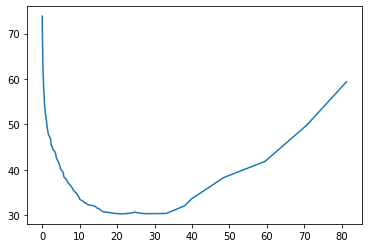

In [60]:
x = thresholds
y = variances
plt.plot(x,y)

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [95]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None,
                 min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical",
                           feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self.feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(0, sub_X.shape[1]):
            feature_type = self.feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click/current_count
                sorted_categories = list(map(lambda x: x[0],
                                             sorted(ratio.items(),
                                                    key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories,
                                          list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if len(feature_vector) == 0:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, np.array(sub_y))
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold,
                                                     categories_map.items())))
                else:
                    raise ValueError

        if gini_best == -1:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self.feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self.feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)],
                       sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        x = np.array(x)
        tree = node
        class_i = None
        for i in range(100):
            if tree['type'] == 'terminal':
                class_i = tree['class']
                break
            else:
                feature_split_i = tree['feature_split']
                if self.feature_types[tree['feature_split']] == 'real':
                    real_split_i = tree['threshold']
                    if x[feature_split_i] < real_split_i:
                        tree = tree['left_child']
                    else:
                        tree = tree['right_child']
                else:
                    categories_split_i = tree['categories_split']
                    if x[feature_split_i] in categories_split_i:
                        tree = tree['left_child']
                    else:
                        tree = tree['right_child']
        return class_i

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)
#https://gist.github.com/SlayZar/7289d578297275e2569f36b02822358b#file-ml-L71

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [62]:
import pandas as pd

df = pd.read_csv('students.csv')
df

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


[('PEG', 0.615, 0.0860656027491214),
 ('STG', 0.615, 0.45397707504410645),
 ('LPR', 0.615, 0.4546683192930121),
 ('SCG', 0.615, 0.4650194980401841),
 ('STR', 0.615, 0.46733829445545116)]

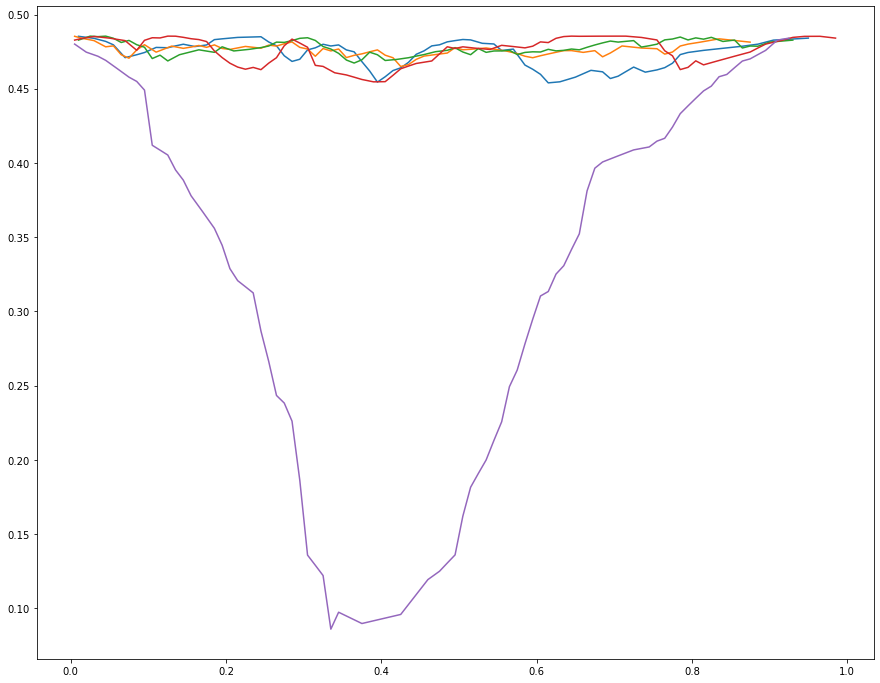

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [63]:
results = []
fig, ax = plt.subplots(figsize = (15, 12))

for i in range(5):
    thes, ginis, t_best, Gini = find_best_split(df.iloc[:,i], df.iloc[:,5], 'classification', 'real')
    results.append((df.columns[i], t, Gini))
    plt.figure()
    ax.plot(thes, ginis)
    
results = sorted(results, key=lambda x: x[2])
results

#https://github.com/V-Marco/hse_iad5_2021/blob/main/seminar12/sem12_trees.ipynb

Лучшим критерием с наименьшей дисперсией стал фактор PEG, что также можно увидеть на рисунке

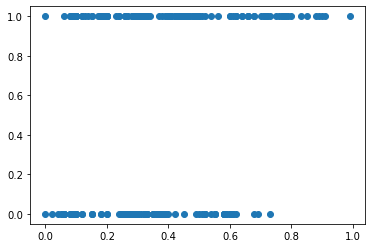

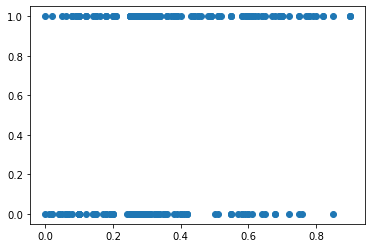

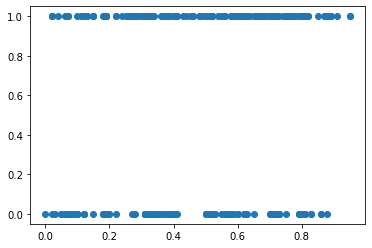

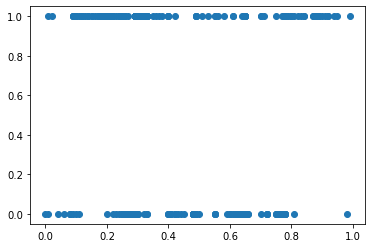

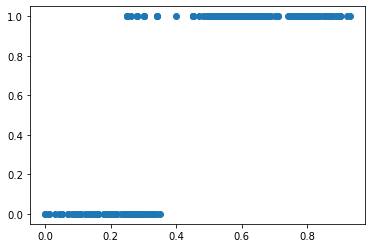

In [17]:
datas = []
for i in range(5):
    plt.scatter(df.iloc[:,i], df.iloc[:,5])
    plt.show()


Тот же факт можно заметить на скэттерах - у фактора PEG проще всего визуально отделить один класс от другого

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Нужно производить деление по признаку PEG, поскольку именно для него дисперсия получается наименьшей (если брать формулу со знаками "+", если брать со знаками "-", то дисперсия должна быть наибольшей). Этот результат полностью согласуется с скэттер графиками, поскольку именно в этом признаке можно наиболее качественно разделить признаки по threshold. Кривая должна иметь четкий глобальный минимум (максимум если с "-") и иметь вид параболы, благодаря этому выборку очень легко разделить по вершине параболы. Кривые же для проблемных признаков имеют очень много минимумов (максимумов), что затрудняет анализ лучшего разбиения

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [90]:
mash = pd.read_csv('mushrooms.csv')

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in mash.columns:
    mash[i] = le.fit_transform(mash[i])

mash

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [91]:
y_mash = mash['class']

In [92]:
X_mash = mash.iloc[:,1:]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_mash, y_mash, test_size=0.5, random_state = 10)

In [94]:
dt = DecisionTree(feature_types = ['categorical']*len(X_train.columns))

dt.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = df.predict(X_test.to_numpy())

accuracy_score(y_test.to_numpy(), y_pred.to_numpy())

ValueError: attempt to get argmin of an empty sequence

## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [27]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [28]:
data = pd.read_csv('diabetes.txt')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

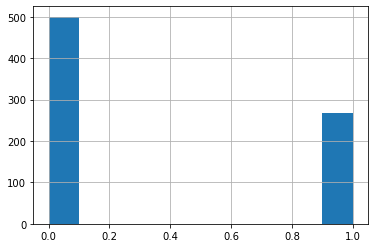

In [29]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [30]:
X = data.iloc[:,0:8]
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 10)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [31]:
bg = BaggingClassifier(n_estimators=50).fit(X_train, y_train)

y_pred = bg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(acc, prec, rec, roc_auc)

0.7532467532467533 0.7272727272727273 0.5517241379310345 0.7133620689655172


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [32]:
rf = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(acc, prec, rec, roc_auc)

0.7489177489177489 0.7543859649122807 0.4942528735632184 0.698515325670498


### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [82]:
n_estimators = np.arange(10, 1510, 150)
min_samples_leaf = np.arange(1, 11)

aucs = pd.DataFrame(columns = {'leafs'})

for i in n_estimators:
    aucs[i] = []

for j in min_samples_leaf:
    est = [j]
    for i in n_estimators:
        rf = RandomForestClassifier(n_estimators=i, min_samples_leaf = j).fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        est.append(roc_auc)
    aucs.loc[j] = est
aucs

,leafs,10,160,310,460,610,760,910,1060,1210,1360
1,1.0,0.667505,0.701988,0.707735,0.687021,0.707735,0.699713,0.696240,0.707735,0.707735,0.698515
2,2.0,0.695043,0.705460,0.690493,0.695043,0.693966,0.698515,0.689296,0.692768,0.696240,0.689296
3,3.0,0.703065,0.704262,0.701988,0.696240,0.698515,0.701988,0.696240,0.687021,0.687021,0.696240
4,4.0,0.689296,0.675527,0.696240,0.690493,0.698515,0.693966,0.697438,0.693966,0.690493,0.693966
5,5.0,0.688099,0.713482,0.678999,0.685943,0.690493,0.682471,0.697438,0.681274,0.688218,0.693966
6,6.0,0.676604,0.688218,0.682471,0.682471,0.682471,0.684746,0.684746,0.678999,0.684746,0.682471
7,7.0,0.669660,0.693966,0.693966,0.678999,0.691691,0.678999,0.688218,0.685943,0.678999,0.682471
8,8.0,0.688099,0.678999,0.678999,0.682471,0.688218,0.688218,0.685943,0.676724,0.682471,0.682471
9,9.0,0.656011,0.681274,0.670977,0.691691,0.678999,0.678999,0.676724,0.682471,0.675527,0.691691
10,10.0,0.677921,0.674449,0.690493,0.673252,0.688218,0.688218,0.678999,0.676724,0.674449,0.685943


In [83]:
aucs.set_index('leafs', inplace=True)
aucs

,10,160,310,460,610,760,910,1060,1210,1360
leafs,,,,,,,,,,
1.0,0.667505,0.701988,0.707735,0.687021,0.707735,0.699713,0.696240,0.707735,0.707735,0.698515
2.0,0.695043,0.705460,0.690493,0.695043,0.693966,0.698515,0.689296,0.692768,0.696240,0.689296
3.0,0.703065,0.704262,0.701988,0.696240,0.698515,0.701988,0.696240,0.687021,0.687021,0.696240
4.0,0.689296,0.675527,0.696240,0.690493,0.698515,0.693966,0.697438,0.693966,0.690493,0.693966
5.0,0.688099,0.713482,0.678999,0.685943,0.690493,0.682471,0.697438,0.681274,0.688218,0.693966
6.0,0.676604,0.688218,0.682471,0.682471,0.682471,0.684746,0.684746,0.678999,0.684746,0.682471
7.0,0.669660,0.693966,0.693966,0.678999,0.691691,0.678999,0.688218,0.685943,0.678999,0.682471
8.0,0.688099,0.678999,0.678999,0.682471,0.688218,0.688218,0.685943,0.676724,0.682471,0.682471
9.0,0.656011,0.681274,0.670977,0.691691,0.678999,0.678999,0.676724,0.682471,0.675527,0.691691


In [84]:
import seaborn as sns

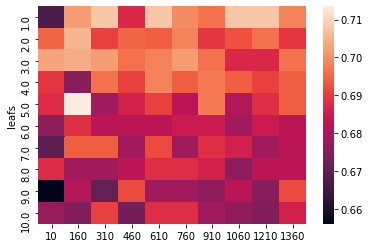

In [85]:
sns.heatmap(aucs)

Худшие результаты показала модель с самым маленьким числом деревьев, слишком большое число деревьев тоже не очень хорошо - происходит переобучение. Оптимальная модель с 160 деревьями, у которой минимум 5 элементов в каждом из листов

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [87]:
rf = RandomForestClassifier(n_estimators=160, min_samples_leaf = 5).fit(X_train, y_train)
y = rf.feature_importances_
x = np.arange(len(y))

<BarContainer object of 8 artists>

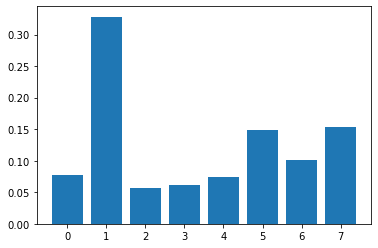

In [88]:
plt.bar(x,y)

In [89]:
z = data.columns
z[1]

'Glucose'

Самый важный признак для определения диабета оказался, что логично, уровень глюкозы